# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_multiple_agents import Agents
from collections import deque
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [5]:
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training the Agents

The code below will train the agents over 2000 episodes.

In [23]:
from ddpg_multiple_agents import Agents
from collections import deque
import torch

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size 
state_size = env_info.vector_observations.shape[1]

In [24]:
agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=12)

In [25]:
scores_deque = deque(maxlen=print_every)
scores = []
mean_scores = []
def ddpg_multiple_agents(n_episodes = 1000, print_every = 100, avg_score_thrd = 0.5):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        agents.reset() # set the noise to zero
        score = np.zeros(num_agents)
        while(True):
            '''
            Following step uses actor network in the structure, it predicts the action vector for each agent, and 
            add a noise to the actions of all agents to improve exploration; then it clips the actions to the range
            of between -1 and +1.
            '''
            actions = agents.act(states) 
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations             # get the next states
            rewards = env_info.rewards                             # get the rewards
            dones = env_info.local_done                            # see if the episode has finished for any agent
            '''
            Following step adds the experience tuples from all agents to the memory replay buffer. And it samples 
            a batch of tuples for updating the actor and critic networks.
            Both actor and critic updates here applied the dueling network settings (similar to DQN), which means 
            for both actor and critic networks, we have a local network and a target network. Target networks are
            used to predict results (action or Q-value), and we use these predicted expected results to update the
            local network parameters.
            -- To update the critic
                    i)   Get the next action by feeding next state into target actor 
                    ii)  Get the action-value of next state/next action pair by feeding these into target critic - call this Q_next
                    iii) Compute the 'actual' Q value for the current state/action pair as Q_current = r + γ*Q_next
                    iv)  Get the predicted Q by feeding the current state and current action into the local critic - call this Q_pred
                    v)   Compute the MSE loss between Q_current and Q_predicted, and update the weights of the local critic
            -- To update the actor
                    i)   Get the predicted actions for the current states based on the local actor
                    ii)  Get the Q-values (expected reward) of these by passing the current states and predicted actions through the local critic
                    iii) Use the negative mean of the Q-values as a loss to update the weights of the local actor
            -- To update the target networks
                    Update the actor and critic target network weights by moving these slightly toward the local weights (soft-update)   
            '''
            agents.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break
        scores_deque.append(np.max(score)) # contains the last 'print_every' (=100) average scores for each agent
        scores.append(np.max(score))
        mean_scores.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if len(scores_deque) == print_every:
            mean_score = np.mean(scores_deque)
            if mean_score > avg_score_thrd:
                torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
                avg_score_thrd = mean_score

In [26]:
n_episodes = 2000
print_every = 100
thrd = 0.5
ddpg_multiple_agents(n_episodes, print_every, thrd)

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.22
Episode 700	Average Score: 0.22
Episode 800	Average Score: 1.26
Episode 900	Average Score: 0.37
Episode 1000	Average Score: 0.19
Episode 1100	Average Score: 0.77
Episode 1200	Average Score: 0.78
Episode 1300	Average Score: 0.99
Episode 1400	Average Score: 0.85
Episode 1500	Average Score: 0.91
Episode 1600	Average Score: 0.97
Episode 1700	Average Score: 1.15
Episode 1800	Average Score: 1.18
Episode 1900	Average Score: 0.74
Episode 2000	Average Score: 0.74


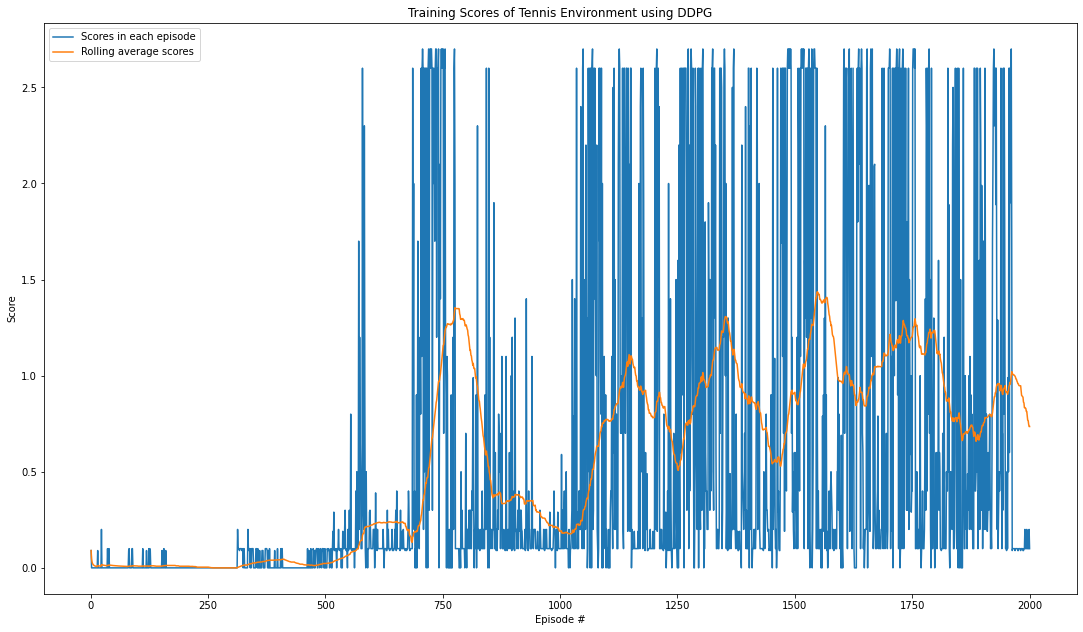

In [36]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label = "Scores in each episode")
plt.plot(np.arange(1, len(mean_scores)+1), mean_scores, label = "Rolling average scores")
plt.title('Training Scores of Tennis Environment using DDPG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()
fig.savefig('test2png.png', dpi=100)

In [37]:
env.close()